In [ ]:
import pylab as plt
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from urllib.request import urlopen
import pickle

url = 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'
data = pickle.load(urlopen(url))

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(1000, 40)


In [ ]:
!pip install mnist1d

In [ ]:
from mnist1d.data import make_dataset, get_dataset_args

args = get_dataset_args()
args.num_samples = 16_000
args.train_split = 0.25

data = make_dataset(args)

print(data['x'].shape)
print(data['x_test'].shape)

(4000, 40)
(12000, 40)


In [ ]:
import copy
data_with_label_noise = copy.deepcopy(data)

for i in range(len(data['y'])):
    if np.random.random_sample() < 0.15:
        data_with_label_noise['y'][i] = np.random.randint(0, 10)

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
def fit_model(model, data, n_epoch=500):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    x_train = torch.tensor(data["x"].astype("float32"))
    y_train = torch.tensor(data["y"].astype("long"))
    x_test = torch.tensor(data["x_test"].astype("float32"))
    y_test = torch.tensor(data["y_test"].astype("long"))

    data_loader = DataLoader(
        TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )

    for epoch in range(n_epoch):
        for i, (x_batch, y_batch) in enumerate(data_loader):
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_function(pred, y_batch)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            pred_train = model(x_train)
            pred_test = model(x_test)

            _, predicted_train_class = torch.max(pred_train.data, 1)
            _, predicted_test_class = torch.max(pred_test.data, 1)

            errors_train = 100 * (predicted_train_class != y_train).float().mean()
            errors_test = 100 * (predicted_test_class != y_test).float().mean()
            losses_train = loss_function(pred_train, y_train).item()
            losses_test = loss_function(pred_test, y_test).item()

            print(
                f"Epoch {epoch + 1:5d}, "
                f"Train Loss: {losses_train:.6f}, Train Error: {errors_train:3.2f}%, "
                f"Test Loss: {losses_test:.6f}, Test Error: {errors_test:3.2f}%"
            )

    return errors_train, errors_test

In [ ]:
# training without label noise
hidden_variables = np.unique(np.geomspace(2, 200, 20, dtype=int))

errors_train_raw = np.zeros_like(hidden_variables)
errors_test_raw = np.zeros_like(hidden_variables)

for i, size in enumerate(hidden_variables):
    print(f'Training model with {size:3d} hidden variables')

    model = SimpleMLP(40, size, 10)
    errors_train, errors_test = fit_model(model, data)
    errors_train_raw[i] = errors_train
    errors_test_raw[i] = errors_test

Streaming output truncated to the last 5000 lines.
Epoch    10, Train Loss: 1.582612, Train Error: 63.60%, Test Loss: 1.626070, Test Error: 64.93%
Epoch    11, Train Loss: 1.546682, Train Error: 61.67%, Test Loss: 1.588770, Test Error: 63.78%
Epoch    12, Train Loss: 1.500996, Train Error: 60.00%, Test Loss: 1.546874, Test Error: 61.40%
Epoch    13, Train Loss: 1.452144, Train Error: 57.38%, Test Loss: 1.505023, Test Error: 59.28%
Epoch    14, Train Loss: 1.410640, Train Error: 55.20%, Test Loss: 1.465918, Test Error: 57.60%
Epoch    15, Train Loss: 1.378135, Train Error: 54.38%, Test Loss: 1.439827, Test Error: 57.41%
Epoch    16, Train Loss: 1.348772, Train Error: 52.53%, Test Loss: 1.414730, Test Error: 55.90%
Epoch    17, Train Loss: 1.327082, Train Error: 51.67%, Test Loss: 1.404924, Test Error: 55.85%
Epoch    18, Train Loss: 1.306677, Train Error: 50.92%, Test Loss: 1.382288, Test Error: 54.81%
Epoch    19, Train Loss: 1.295922, Train Error: 50.80%, Test Loss: 1.379367, Test Err

In [ ]:
# training with label noise
hidden_variables = np.unique(np.geomspace(2, 200, 20, dtype=int))

errors_train_raw = np.zeros_like(hidden_variables)
errors_test_raw = np.zeros_like(hidden_variables)

for i, size in enumerate(hidden_variables):
    print(f'Training model with {size:3d} hidden variables')

    model = SimpleMLP(40, size, 10)
    errors_train, errors_test = fit_model(model, data_with_label_noise)
    errors_train_raw[i] = errors_train
    errors_test_raw[i] = errors_test

Streaming output truncated to the last 5000 lines.
Epoch    10, Train Loss: 1.878708, Train Error: 69.72%, Test Loss: 1.747171, Test Error: 68.40%
Epoch    11, Train Loss: 1.867586, Train Error: 70.07%, Test Loss: 1.728904, Test Error: 67.92%
Epoch    12, Train Loss: 1.855993, Train Error: 68.60%, Test Loss: 1.721102, Test Error: 66.72%
Epoch    13, Train Loss: 1.842033, Train Error: 68.45%, Test Loss: 1.703803, Test Error: 66.47%
Epoch    14, Train Loss: 1.826274, Train Error: 66.80%, Test Loss: 1.686985, Test Error: 64.61%
Epoch    15, Train Loss: 1.808261, Train Error: 65.53%, Test Loss: 1.670634, Test Error: 63.96%
Epoch    16, Train Loss: 1.790271, Train Error: 64.70%, Test Loss: 1.646862, Test Error: 62.24%
Epoch    17, Train Loss: 1.772428, Train Error: 62.35%, Test Loss: 1.629174, Test Error: 60.42%
Epoch    18, Train Loss: 1.753342, Train Error: 62.48%, Test Loss: 1.601712, Test Error: 60.80%
Epoch    19, Train Loss: 1.737172, Train Error: 60.18%, Test Loss: 1.581705, Test Err

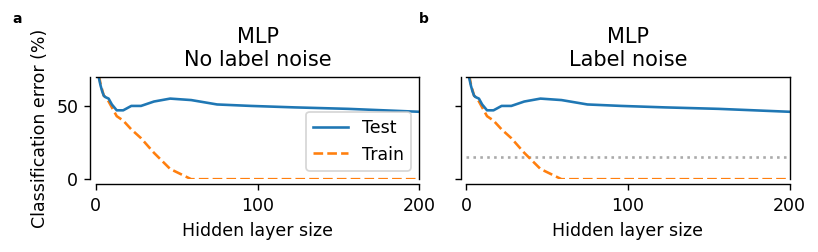

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(6.5, 2), dpi=125)

# Plot for MLP without label noise
axs[0].plot(hidden_variables, errors_test_raw, '-', label='Test')
axs[0].plot(hidden_variables, errors_train_raw, '--', label='Train', zorder=0)

axs[0].set_ylim(0, 70)
axs[0].set_xlim(0, 200)
axs[0].set_xticks([0, 100, 200])
axs[0].set_xlabel('Hidden layer size')
axs[0].set_ylabel('Classification error (%)')
axs[0].legend()
axs[0].set_title('MLP\nNo label noise')

axs[0].spines.left.set_position(('outward', 3))
axs[0].spines.bottom.set_position(('outward', 3))

# Plot for MLP with label noise
axs[1].plot(hidden_variables, errors_test_raw, '-', label='Test')
axs[1].plot(hidden_variables, errors_train_raw, '--', label='Train', zorder=0)

axs[1].set_ylim(0, 70)
axs[1].set_xlim(0, 200)
axs[1].set_xticks([0, 100, 200])
axs[1].set_xlabel('Hidden layer size')
axs[1].set_yticklabels([])
axs[1].set_title('MLP\nLabel noise')
axs[1].plot([0, 300], [15, 15], ':', zorder=-1, color='#aaaaaa')

axs[1].spines.left.set_position(('outward', 3))
axs[1].spines.bottom.set_position(('outward', 3))

# Adding figure labels
fig.text(0, .94, 'a', fontsize=8, weight='bold')
fig.text(.5, .94, 'b', fontsize=8, weight='bold')

plt.tight_layout()
plt.show()


In [ ]:
def run_experiment(data, input_size=40, hidden_size=50, output_size=10,
                   n_layers=2, label_noise=0.15, lr=0.01, batch_size=100, n_epoch=500):
    # label noise if required
    if label_noise > 0:
        data_noisy = copy.deepcopy(data)
        for i in range(len(data_noisy['y'])):
            if np.random.random_sample() < label_noise:
                data_noisy['y'][i] = np.random.randint(0, output_size)
        data = data_noisy

    # architecture
    layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    for _ in range(n_layers - 1):
        layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
    layers += [nn.Linear(hidden_size, output_size)]
    model = nn.Sequential(*layers)

    return fit_model(model, data, n_epoch=n_epoch)


**A. Effect of Hidden Layers**

In [ ]:
layer_results = {}
for n_layers in [1, 2, 3]:
    print(f"Testing {n_layers} hidden layers...")
    errors_train, errors_test = run_experiment(data, hidden_size=50, n_layers=n_layers)
    layer_results[n_layers] = (errors_train, errors_test)


Testing 1 hidden layers...
Epoch     1, Train Loss: 2.178617, Train Error: 79.80%, Test Loss: 2.167262, Test Error: 79.61%
Epoch     2, Train Loss: 2.016774, Train Error: 77.00%, Test Loss: 1.973410, Test Error: 76.91%
Epoch     3, Train Loss: 1.939720, Train Error: 74.60%, Test Loss: 1.866915, Test Error: 74.18%
Epoch     4, Train Loss: 1.903739, Train Error: 71.72%, Test Loss: 1.813906, Test Error: 71.26%
Epoch     5, Train Loss: 1.881186, Train Error: 69.07%, Test Loss: 1.784575, Test Error: 69.17%
Epoch     6, Train Loss: 1.864056, Train Error: 70.45%, Test Loss: 1.759210, Test Error: 69.48%
Epoch     7, Train Loss: 1.845795, Train Error: 67.60%, Test Loss: 1.742618, Test Error: 66.91%
Epoch     8, Train Loss: 1.831458, Train Error: 66.53%, Test Loss: 1.729650, Test Error: 67.33%
Epoch     9, Train Loss: 1.813745, Train Error: 66.05%, Test Loss: 1.706343, Test Error: 65.86%
Epoch    10, Train Loss: 1.795781, Train Error: 63.15%, Test Loss: 1.693354, Test Error: 64.12%
Epoch    11, 

**B. Effect of label noise**

In [ ]:
noise_results = {}
for noise in [0.0, 0.1, 0.15, 0.2, 0.3]:
    print(f"Testing label noise: {noise * 100:.0f}%")
    errors_train, errors_test = run_experiment(data, label_noise=noise)
    noise_results[noise] = (errors_train, errors_test)


Testing label noise: 0%
Epoch     1, Train Loss: 2.221729, Train Error: 78.90%, Test Loss: 2.228092, Test Error: 80.70%
Epoch     2, Train Loss: 1.992187, Train Error: 77.90%, Test Loss: 2.011924, Test Error: 78.99%
Epoch     3, Train Loss: 1.803516, Train Error: 73.85%, Test Loss: 1.831860, Test Error: 75.52%
Epoch     4, Train Loss: 1.720416, Train Error: 70.82%, Test Loss: 1.750188, Test Error: 71.97%
Epoch     5, Train Loss: 1.674810, Train Error: 67.98%, Test Loss: 1.709629, Test Error: 70.18%
Epoch     6, Train Loss: 1.641048, Train Error: 65.28%, Test Loss: 1.679876, Test Error: 67.61%
Epoch     7, Train Loss: 1.608951, Train Error: 65.50%, Test Loss: 1.652244, Test Error: 67.54%
Epoch     8, Train Loss: 1.576089, Train Error: 61.58%, Test Loss: 1.627349, Test Error: 65.54%
Epoch     9, Train Loss: 1.537779, Train Error: 61.30%, Test Loss: 1.587190, Test Error: 63.69%
Epoch    10, Train Loss: 1.488635, Train Error: 57.17%, Test Loss: 1.550368, Test Error: 61.41%
Epoch    11, Tra

**C. Effect of hidden layer Sizes**

In [ ]:
hidden_size_results = {}
for hidden_size in [10, 50, 100, 200]:
    print(f"Testing hidden size: {hidden_size}")
    errors_train, errors_test = run_experiment(data, hidden_size=hidden_size)
    hidden_size_results[hidden_size] = (errors_train, errors_test)


Testing hidden size: 10
Epoch     1, Train Loss: 2.274913, Train Error: 84.38%, Test Loss: 2.269637, Test Error: 83.62%
Epoch     2, Train Loss: 2.202916, Train Error: 80.03%, Test Loss: 2.187585, Test Error: 79.08%
Epoch     3, Train Loss: 2.060539, Train Error: 79.58%, Test Loss: 2.006083, Test Error: 78.66%
Epoch     4, Train Loss: 1.978218, Train Error: 76.10%, Test Loss: 1.884950, Test Error: 75.22%
Epoch     5, Train Loss: 1.948540, Train Error: 75.57%, Test Loss: 1.831666, Test Error: 73.93%
Epoch     6, Train Loss: 1.932377, Train Error: 72.88%, Test Loss: 1.806916, Test Error: 71.78%
Epoch     7, Train Loss: 1.921281, Train Error: 73.03%, Test Loss: 1.790499, Test Error: 71.23%
Epoch     8, Train Loss: 1.912441, Train Error: 72.07%, Test Loss: 1.777361, Test Error: 70.71%
Epoch     9, Train Loss: 1.904246, Train Error: 70.65%, Test Loss: 1.768117, Test Error: 69.87%
Epoch    10, Train Loss: 1.898196, Train Error: 70.55%, Test Loss: 1.764027, Test Error: 69.49%
Epoch    11, Tra

In [ ]:
def run_with_dropout(data, input_size=40, hidden_size=50, output_size=10,
                     n_layers=2, dropout=0.2, **kwargs):
    layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
    for _ in range(n_layers - 1):
        layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
    layers += [nn.Linear(hidden_size, output_size)]
    model = nn.Sequential(*layers)
    return fit_model(model, data, **kwargs)

dropout_results = {}
for dropout_rate in [0.0, 0.1, 0.3, 0.5]:
    print(f"Testing dropout rate: {dropout_rate}")
    errors_train, errors_test = run_with_dropout(data, dropout=dropout_rate)
    dropout_results[dropout_rate] = (errors_train, errors_test)


Testing dropout rate: 0.0
Epoch     1, Train Loss: 2.268456, Train Error: 81.22%, Test Loss: 2.273448, Test Error: 82.21%
Epoch     2, Train Loss: 2.138779, Train Error: 77.47%, Test Loss: 2.153602, Test Error: 79.62%
Epoch     3, Train Loss: 1.890899, Train Error: 76.97%, Test Loss: 1.920502, Test Error: 78.22%
Epoch     4, Train Loss: 1.775381, Train Error: 74.40%, Test Loss: 1.804333, Test Error: 75.64%
Epoch     5, Train Loss: 1.723760, Train Error: 70.45%, Test Loss: 1.756146, Test Error: 72.26%
Epoch     6, Train Loss: 1.693044, Train Error: 71.20%, Test Loss: 1.728086, Test Error: 72.04%
Epoch     7, Train Loss: 1.666777, Train Error: 66.43%, Test Loss: 1.708986, Test Error: 68.97%
Epoch     8, Train Loss: 1.647449, Train Error: 67.00%, Test Loss: 1.692915, Test Error: 69.19%
Epoch     9, Train Loss: 1.630114, Train Error: 64.88%, Test Loss: 1.675105, Test Error: 68.10%
Epoch    10, Train Loss: 1.609978, Train Error: 63.30%, Test Loss: 1.663935, Test Error: 66.47%
Epoch    11, T

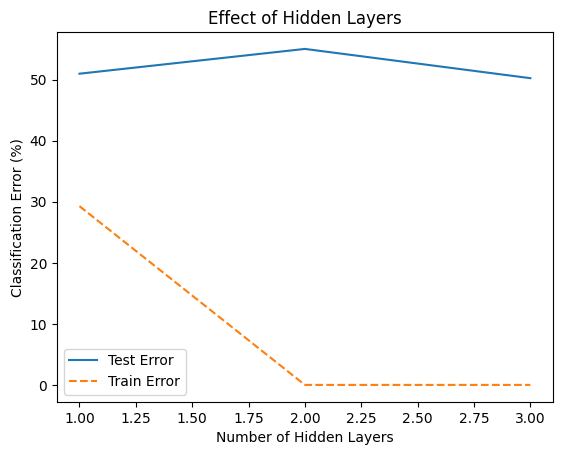

In [ ]:
layers, train_errors, test_errors = zip(*[(k, v[0], v[1]) for k, v in layer_results.items()])
plt.plot(layers, test_errors, label='Test Error')
plt.plot(layers, train_errors, label='Train Error', linestyle='--')
plt.xlabel("Number of Hidden Layers")
plt.ylabel("Classification Error (%)")
plt.title("Effect of Hidden Layers")
plt.legend()
plt.show()


The graph above shows the effect of number of hidden layers on train and test error:

1.   For Train error:  As the number of hidden layers are increasing the error seems to be decreasing and drop down to zero when hidden layers in number went to 2 and continues.
2.   For Test error: The curve is similar to the graph of Deep Double Descent phemonenon graph obtained above, the error is increasing upto 2, reaches maximum at 2, then drops down.\

For this graph, I am changing only number of hidden layer, other parameters are constant, and in graph we can see that, 2 is the point of change.


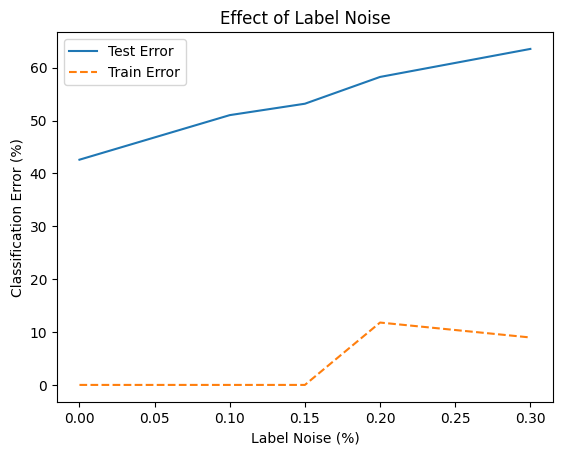

In [ ]:
noises, train_errors, test_errors = zip(*[(k, v[0], v[1]) for k, v in noise_results.items()])
plt.plot(noises, test_errors, label='Test Error')
plt.plot(noises, train_errors, label='Train Error', linestyle='--')
plt.xlabel("Label Noise (%)")
plt.ylabel("Classification Error (%)")
plt.title("Effect of Label Noise")
plt.legend()
plt.show()


The above shows the effect of label noise on both the errors while keeping other parameters constant.\
Isn't it attention grabbing that the test error is increasing as label noise is incresing, but look at the Train error, it remained zero till 0.15, increases till 0.2 then starts decreasing after 0.2. What I think about this that model is trying to fit these noisy labels during training, this often means that the model is memorizing the training data, including its noise, quite interesting.

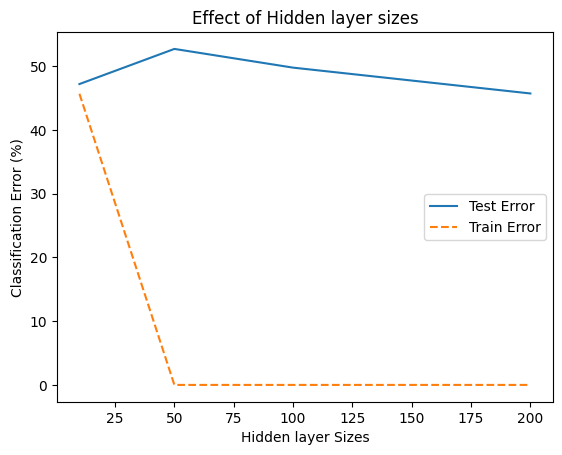

In [ ]:
units, train_errors, test_errors = zip(*[(k, v[0], v[1]) for k, v in hidden_size_results.items()])
plt.plot(units, test_errors, label='Test Error')
plt.plot(units, train_errors, label='Train Error', linestyle='--')
plt.xlabel("Hidden layer Sizes")
plt.ylabel("Classification Error (%)")
plt.title("Effect of Hidden layer sizes")
plt.legend()
plt.show()


It has a similar shape same as of the graph obtained for varying number of hidden layers, same explaination can be interpreted here.

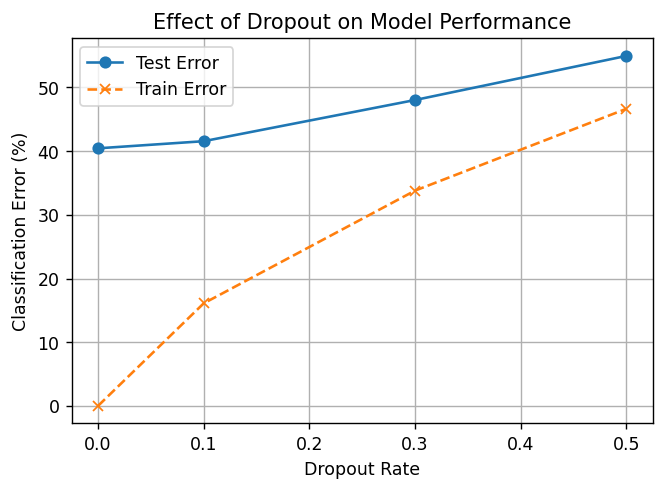

In [ ]:
# Extract data for plotting
dropouts, train_errors, test_errors = zip(*[(k, v[0], v[1]) for k, v in dropout_results.items()])

# Plot the graph
plt.figure(figsize=(6, 4), dpi=125)
plt.plot(dropouts, test_errors, label='Test Error', marker='o')
plt.plot(dropouts, train_errors, label='Train Error', linestyle='--', marker='x')
plt.xlabel("Dropout Rate")
plt.ylabel("Classification Error (%)")
plt.title("Effect of Dropout on Model Performance")
plt.legend()
plt.grid(True)
plt.show()


Dropout regularization is a technique used in training neural networks to prevent overfitting and decreasing errors. Here both the errors are increasing as dropout rate increases, the most probable explanation for this can be underfitting. Overfitting is not creating a good impact on this network as underfitting is doing. We can interpret that no dropout is required here as there is no overfitting.

## Combining the effects of changing parameters

In [ ]:
def run_combined_experiment(data, input_size=40, hidden_size=50, output_size=10,
                            n_layers=2, label_noise=0.15, dropout=0.0, n_epoch=500):

    if label_noise > 0:
        noisy_data = copy.deepcopy(data)
        for i in range(len(noisy_data['y'])):
            if np.random.random_sample() < label_noise:
                noisy_data['y'][i] = np.random.randint(0, output_size)
        data = noisy_data

    # model with dropout and configurable layers
    layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
    for _ in range(n_layers - 1):
        layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Dropout(dropout)]
    layers += [nn.Linear(hidden_size, output_size)]
    model = nn.Sequential(*layers)

    # Use fixed lr and batch_size inside the function
    return fit_model(model, data, n_epoch=n_epoch)


In [ ]:
# Parameter values to vary
hidden_sizes = [10, 50, 100]
n_layers_options = [1, 2, 3]
label_noise_levels = [0.0, 0.1, 0.2]
dropout_rates = [0.0, 0.1, 0.3]

# Store results
combined_results = []

for hidden_size in hidden_sizes:
    for n_layers in n_layers_options:
        for label_noise in label_noise_levels:
            for dropout_rate in dropout_rates:
                print(f"Hidden Size: {hidden_size}, Layers: {n_layers}, Noise: {label_noise}, Dropout: {dropout_rate}")
                errors_train, errors_test = run_combined_experiment(
                    data, hidden_size=hidden_size, n_layers=n_layers,
                    label_noise=label_noise, dropout=dropout_rate, n_epoch=500
                )
                combined_results.append({
                    "hidden_size": hidden_size,
                    "n_layers": n_layers,
                    "label_noise": label_noise,
                    "dropout_rate": dropout_rate,
                    "train_error": errors_train,
                    "test_error": errors_test
                })



Streaming output truncated to the last 5000 lines.
Epoch    10, Train Loss: 1.918408, Train Error: 69.92%, Test Loss: 1.777740, Test Error: 68.60%
Epoch    11, Train Loss: 1.896066, Train Error: 68.78%, Test Loss: 1.757535, Test Error: 68.06%
Epoch    12, Train Loss: 1.893586, Train Error: 67.08%, Test Loss: 1.738566, Test Error: 65.82%
Epoch    13, Train Loss: 1.880098, Train Error: 67.70%, Test Loss: 1.725166, Test Error: 65.59%
Epoch    14, Train Loss: 1.861024, Train Error: 67.10%, Test Loss: 1.708369, Test Error: 65.26%
Epoch    15, Train Loss: 1.850830, Train Error: 66.25%, Test Loss: 1.698623, Test Error: 64.57%
Epoch    16, Train Loss: 1.846459, Train Error: 65.78%, Test Loss: 1.680511, Test Error: 63.75%
Epoch    17, Train Loss: 1.831673, Train Error: 64.92%, Test Loss: 1.670662, Test Error: 63.86%
Epoch    18, Train Loss: 1.835558, Train Error: 65.00%, Test Loss: 1.658805, Test Error: 62.25%
Epoch    19, Train Loss: 1.816511, Train Error: 63.58%, Test Loss: 1.643179, Test Err

In [ ]:
import pandas as pd

# Convert results into a DataFrame
results_df = pd.DataFrame(combined_results)

print(results_df.head())


   hidden_size  n_layers  label_noise  dropout_rate      train_error  \
0           10         1          0.0           0.0  tensor(45.4250)   
1           10         1          0.0           0.1  tensor(53.1250)   
2           10         1          0.0           0.3  tensor(59.3750)   
3           10         1          0.1           0.0  tensor(47.4750)   
4           10         1          0.1           0.1  tensor(55.5000)   

        test_error  
0  tensor(52.3917)  
1  tensor(58.4667)  
2  tensor(62.8417)  
3  tensor(49.5417)  
4  tensor(56.6000)  


In [ ]:
# Convert train_error and test_error to floats
results_df['train_error'] = results_df['train_error'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
results_df['test_error'] = results_df['test_error'].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


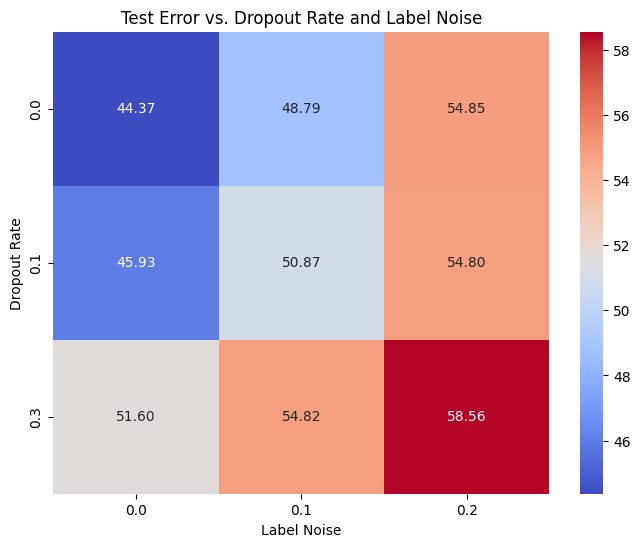

In [ ]:
import seaborn as sns
# Heatmap of test error for varying dropout and noise
heatmap_data = results_df.pivot_table(
    index='dropout_rate',
    columns='label_noise',
    values='test_error',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Test Error vs. Dropout Rate and Label Noise")
plt.xlabel("Label Noise")
plt.ylabel("Dropout Rate")
plt.show()


I have tried combining the effect of all parameters varying, and plotting the heatmap for test errors against dropout rate and label noise, we can also analyse other parameters too, I have just taken this graph to plot to show example.

In [ ]:
#heatmap_data = heatmap_data.astype(float)  # Ensure numeric data

In [ ]:
import pickle

with open('noise_results.pkl', 'wb') as f:
    pickle.dump(noise_results, f)

with open('layer_results.pkl', 'wb') as f:
    pickle.dump(layer_results, f)

with open('combined_results.pkl', 'wb') as f:
    pickle.dump(combined_results, f)

with open('dropout_results.pkl', 'wb') as f:
    pickle.dump(dropout_results, f)

with open('hidden_size_results.pkl', 'wb') as f:
    pickle.dump(hidden_size_results, f)


In [ ]:
# Load results
with open('combined_results.pkl', 'rb') as f:
    combined_results = pickle.load(f)

with open('dropout_results.pkl', 'rb') as f:
    dropout_results = pickle.load(f)

with open('hidden_size_results.pkl', 'rb') as f:
    hidden_size_results = pickle.load(f)

with open('layer_results.pkl', 'rb') as f:
    layer_results = pickle.load(f)

with open('noise_results.pkl', 'rb') as f:
    noise_results = pickle.load(f)